# Initial Exploration

In [1]:
import pandas as pd
import numpy as np

import time

import torch
import torch.nn as nn
import torch.nn.functional as F


import matplotlib.pyplot as plt

import pickle

In [2]:
original_df = pd.read_csv('yelp_academic_dataset_review.csv', usecols=['text', 'stars'], 
                              dtype={'stars':int,'text':str})

In [3]:
len(original_df)

6685900

In [4]:
df = original_df.sample(frac=0.1, replace=True, random_state=1)
len(df)

668590

In [5]:
df.describe()

,stars
count,668590.000000
mean,3.718189
std,1.462876
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [6]:
df = df.reset_index()
df

,index,text,stars
0,4322341,"b""I really enjoyed the tour. Vanessa and Jacki...",5
1,4686059,b'Took us at 7 pm without an appointment. The ...,5
2,3937352,"b""This was my first time at the new library si...",5
3,491263,"b""I've been here about three times and haven't...",4
4,5030793,"b""Being born and raised in Pittsburgh I'm so l...",5
...,...,...,...
668585,3058317,"b""Had an incredible dining experience last nig...",5
668586,2254471,b'This was my second time visiting this locati...,5
668587,2030497,"b""I give Blue Canary Coffee Shop 3 stars for e...",3
668588,6601242,"b""Yummy!!! Five stars because this location is...",5


In [7]:
df['text'][1005]

'b\'Food: 4 stars\\nService: 3.5 stars\\nValue: 4 stars\\n\\nOur friend suggested this little ramen place because it has pretty good reviews on Yelp. The ramen with two thin slices of pork,and the broth were very tasty. The portion was decent and the price was very affordable. I was happy about this place and it definitely made it into my "must go in Vegas" list.\''

In [8]:
df['stars'][1005]

4

# Parameters

In [9]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

# Pre processing

In [10]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x



In [11]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

'this is a text with contraction'

In [12]:
# lower the text
df["text"] = df["text"].apply(lambda x: x.lower())

# Clean the text
df["text"] = df["text"].apply(lambda x: clean_text(x))

# Clean numbers
df["text"] = df["text"].apply(lambda x: clean_numbers(x))

# Clean Contractions
df["text"] = df["text"].apply(lambda x: replace_contractions(x))

In [13]:
df

,index,text,stars
0,4322341,"b""i really enjoyed the tour. vanessa and jacki...",5
1,4686059,b'took us at 7 pm without an appointment. the ...,5
2,3937352,"b""this was my first time at the new library si...",5
3,491263,"b""i have been here about three times and have ...",4
4,5030793,"b""being born and raised in pittsburgh i am so ...",5
...,...,...,...
668585,3058317,"b""had an incredible dining experience last nig...",5
668586,2254471,b'this was my second time visiting this locati...,5
668587,2030497,"b""i give blue canary coffee shop 3 stars for e...",3
668588,6601242,"b""yummy!!! five stars because this location is...",5


# Creating the dataset

In [14]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(df["text"], df["stars"], test_size=0.33, random_state=42)

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Save tokenizer

In [16]:
with open('tokenizer', 'wb') as f:
    pickle.dump(tokenizer, f)

In [17]:
train_X

array([[    0,     0,     0, ...,   356,   894,   462],
       [    0,     0,     0, ...,     1,   230,   836],
       [    0,     0,     0, ...,    14, 16155,    38],
       ...,
       [    0,     0,     0, ...,     4,   224,  4397],
       [    0,     0,     0, ...,    76,   191, 12599],
       [    0,     0,     0, ...,     6,  1406,    38]], dtype=int32)

### Creating the labels

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)
le.classes_

array([1, 2, 3, 4, 5])

In [19]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = 'data/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix



In [20]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too

if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/home/guscl/assessments/luma/nlp-interview/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
np.shape(embedding_matrix)

(120000, 300)

## Saving embeddings

In [22]:
with open('embeddings', 'wb') as f:
    pickle.dump(embedding_matrix, f)

## TextCNN

In [23]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

In [24]:
n_epochs = 50
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<ipython-input-24-23f12a68fdd9>:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/50 	 loss=428.9837 	 val_loss=378.2300  	 val_acc=0.6864  	 time=141.51s
Epoch 2/50 	 loss=374.1595 	 val_loss=364.6345  	 val_acc=0.6986  	 time=139.23s
Epoch 3/50 	 loss=359.7011 	 val_loss=360.6273  	 val_acc=0.7020  	 time=139.31s
Epoch 4/50 	 loss=350.0411 	 val_loss=361.1237  	 val_acc=0.7023  	 time=139.47s
Epoch 5/50 	 loss=342.8564 	 val_loss=356.7170  	 val_acc=0.7054  	 time=139.36s
Epoch 6/50 	 loss=336.4858 	 val_loss=356.4691  	 val_acc=0.7065  	 time=139.49s
Epoch 7/50 	 loss=332.0406 	 val_loss=356.1588  	 val_acc=0.7060  	 time=139.35s
Epoch 8/50 	 loss=328.0630 	 val_loss=357.4787  	 val_acc=0.7061  	 time=139.54s
Epoch 9/50 	 loss=323.8118 	 val_loss=359.9343  	 val_acc=0.7046  	 time=139.41s
Epoch 10/50 	 loss=319.9992 	 val_loss=359.8959  	 val_acc=0.7052  	 time=139.45s
Epoch 11/50 	 loss=317.1334 	 val_loss=360.6876  	 val_acc=0.7053  	 time=139.52s
Epoch 12/50 	 loss=314.4351 	 val_loss=362.2237  	 val_acc=0.7038  	 time=139.57s
Epoch 13/50 	 loss=312.11

In [25]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

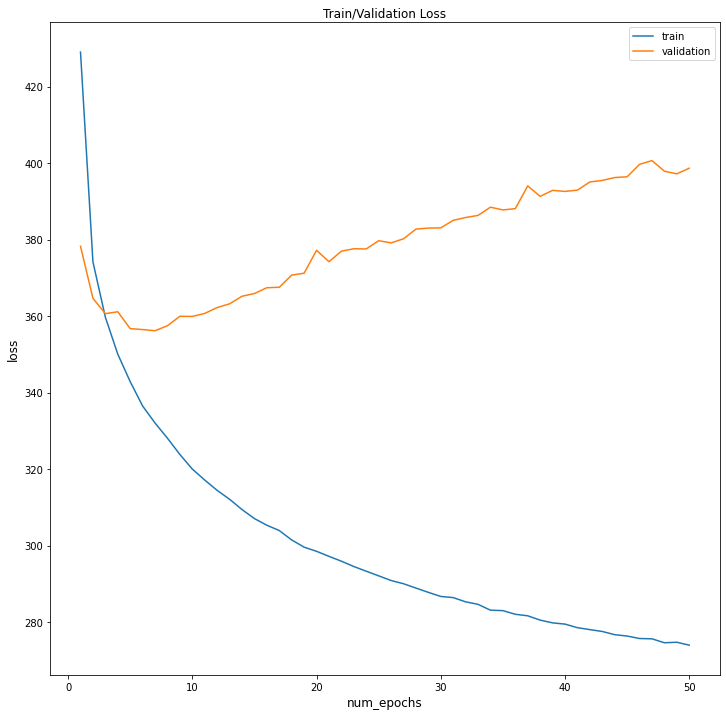

In [26]:
plot_graph(n_epochs)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

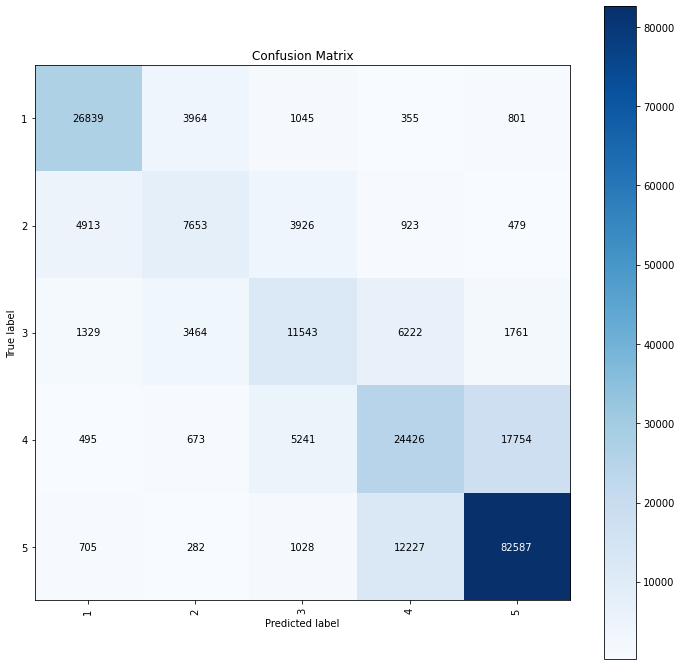

In [27]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)



### Confusion matrix analysis

The acc of the model was 70%, wich is not very good. By looking at the confusion matrix it's possible to see that the biggest error it's in classes 4 and 5. That won't be a problem, because in the end 4 and 5 will be joined to become the 'good' class. 1 and 2 will become 'bad' and 3 will become 'neutral'. 1 and 2 are also very mixed, wich is good, because they will be joined as well. In the end the 70% acc is not a bad result.

In [28]:
torch.save(model,'textcnn_entire')
torch.save(model.state_dict(), 'textcnn_state_dict')
torch.jit.save(torch.jit.script(model), 'textcnn_jit')

## BiLSTM test
I will check to see if bilstm performs better, fewer epochs will be used, trainning was taking too long.

In [21]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out



In [22]:
batch_size = 128

In [23]:
n_epochs = 15
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<ipython-input-23-3d6d3b65fd37>:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/1 	 loss=101.7115 	 val_loss=90.8562  	 val_acc=0.6968  	 time=224.66s


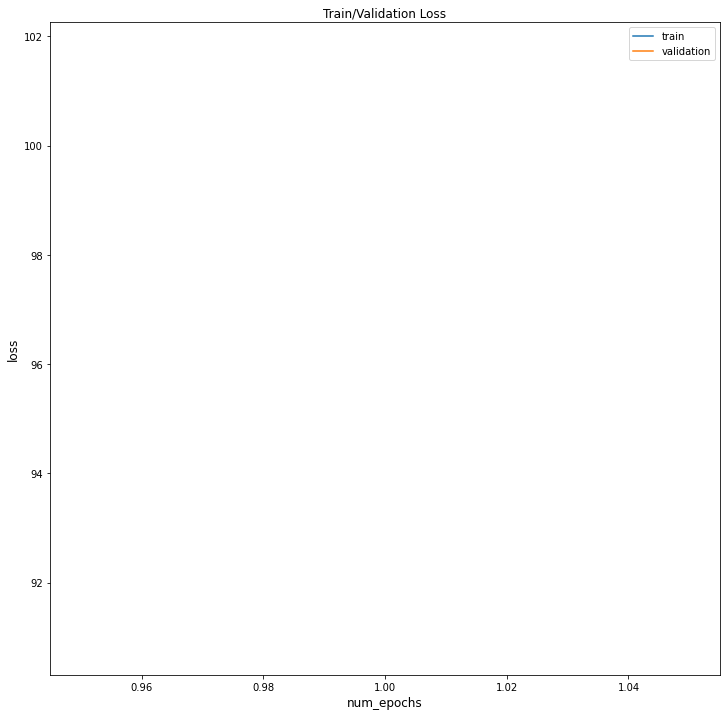

In [26]:
plot_graph(n_epochs)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

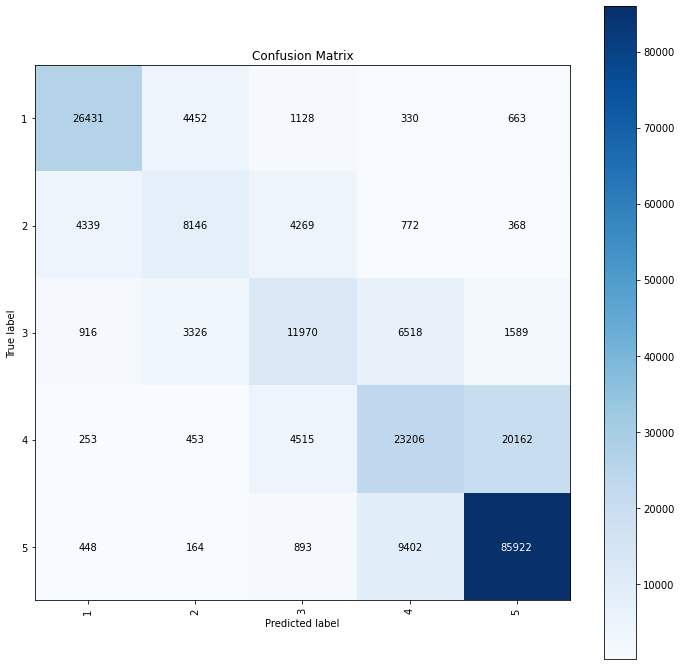

In [29]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)



### Confusion matrix analysis

Same results as seen before.

In [31]:
#torch.jit.save(torch.jit.script(model), 'bilstm_jit')
#torch.save(model,'bilstm_yelp')

In [73]:
def predict_single(x): 
    print('x', x)
    print('len(x)', len(x))
    print('type(x)', type(x))
    # lower the text
    x = x.lower()
    # Clean the text
    x =  clean_text(x)
    # Clean numbers
    x =  clean_numbers(x)
    # Clean Contractions
    x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    print('x', x)
    print('len(x)', len(x))
    print('type(x)', type(x))
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()
    


    
    pred = model(x).detach()
    
    pred = F.softmax(pred).cpu().numpy()
    
    
    pred = pred.argmax(axis=1)
    
    
    pred = le.classes_[pred]
    return pred[0]

In [74]:
x = df['text'].values[805]
print('x',x)
print('y',df['stars'].values[805])

x b"the staff turnover at this school has been unacceptable. the enrollment is dropping as a result. my daughter has been enrolled for 9 months and she has gone through 4 teachers. she seems to like the other students so i am keeping her enrolled but it seems that they cannot keep their staff happy-likely as owners are out-of-state. i specifically asked about staff turnover during the interviewing process and i was lied to. their hours are convenient which is a plus, but i regret my decision. i wanted to ask about how her language and development skills are in comparison to the other students but i am not going to bother as it is a revolving door with staff-they would not know."
y 2


In [75]:
predict_single(x)

x b"the staff turnover at this school has been unacceptable. the enrollment is dropping as a result. my daughter has been enrolled for 9 months and she has gone through 4 teachers. she seems to like the other students so i am keeping her enrolled but it seems that they cannot keep their staff happy-likely as owners are out-of-state. i specifically asked about staff turnover during the interviewing process and i was lied to. their hours are convenient which is a plus, but i regret my decision. i wanted to ask about how her language and development skills are in comparison to the other students but i am not going to bother as it is a revolving door with staff-they would not know."
len(x) 685
type(x) <class 'str'>
x [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0

<ipython-input-73-32c95078cc25>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(pred).cpu().numpy()


1